# Balanced Exoplanet Classifier

This notebook implements a machine learning model to classify exoplanets based on data from various space missions including Kepler, K2, and TESS. The classifier uses LightGBM to categorize celestial objects into three classes:
- Confirmed Exoplanets
- Candidate Exoplanets
- False Positives

The model takes into account various astronomical parameters and achieves balanced classification through careful feature engineering and data preprocessing.

### Required Libraries and Dependencies

This section imports the necessary Python libraries:
- pandas: For data manipulation and analysis
- numpy: For numerical operations
- sklearn: For machine learning tools and metrics
- lightgbm: For the gradient boosting classifier implementation

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from lightgbm import LGBMClassifier

### Data Source Configuration

Setting up URLs for different exoplanet datasets from NASA's Exoplanet Archive:
- Planetary Systems (PS): Complete database of confirmed exoplanets
- Kepler: Exoplanets discovered by the Kepler Space Telescope
- Kepler Objects of Interest (KOI): Candidate planets from Kepler mission
- K2: Candidates and confirmed planets from K2 mission
- TESS Objects of Interest (TOI): Candidates from TESS mission

Each URL points to a specific dataset in CSV format accessible through the IPAC TAP service.

In [10]:
URLS = {
    "ps": "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps&format=csv",
    "kepler": "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps+where+disc_facility+=+'Kepler'&format=csv",
    "koi": "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+cumulative&format=csv",
    "k2": "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+k2pandc&format=csv",
    "k2_confirmed": "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps+where+disc_facility+=+'K2'&format=csv",
    "tess": "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+toi&format=csv",
    "tess_confirmed": "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps+where+disc_facility+=+'TESS'&format=csv",
}

### loading data

In [11]:
def load_csv(url, usecols=None):
    try:
        return pd.read_csv(url, usecols=usecols, low_memory=False)
    except Exception as e:
        print(f"Error loading {url}: {e}")
        return pd.DataFrame()

### Feature Selection

Defining the key astronomical parameters used for classification:
- orb_period: Orbital period of the planet (days)
- planet_radius: Radius of the planet (Earth radii)
- planet_mass: Mass of the planet (Earth masses)
- pl_eqt: Equilibrium temperature of the planet
- st_teff: Effective temperature of the host star
- st_rad: Radius of the host star (Solar radii)
- st_mass: Mass of the host star (Solar masses)
- sy_dist: Distance to the planetary system
- transit_depth: Depth of the transit signal
- transit_duration: Duration of the transit

In [12]:
cols_common = ["orb_period", "planet_radius", "planet_mass", "pl_eqt",
               "st_teff", "st_rad", "st_mass", "sy_dist",
               "transit_depth", "transit_duration"]

df_ps = load_csv(URLS["ps"])
df_kepler = load_csv(URLS["kepler"])
df_koi = load_csv(URLS["koi"])
df_k2 = load_csv(URLS["k2"])
df_k2_conf = load_csv(URLS["k2_confirmed"])
df_tess = load_csv(URLS["tess"])
df_tess_conf = load_csv(URLS["tess_confirmed"])

### Data Harmonization

This section standardizes column names across different datasets:
- Mapping KOI-specific column names to standard names
- Normalizing Planetary System (PS) dataset columns
- Standardizing K2 and TESS candidate datasets
- Adding mission identifiers to track data sources

This ensures consistency in feature names across all datasets before merging.

In [13]:
# KOI dataset
df_koi = df_koi.rename(columns={
    "koi_period": "orb_period",
    "koi_prad": "planet_radius",
    "koi_duration": "transit_duration",
    "koi_depth": "transit_depth",
    "koi_steff": "st_teff",
    "koi_slogg": "st_logg",
    "koi_srad": "st_rad",
    "koi_smass": "st_mass",
    "koi_disposition": "disposition"
})
df_koi["mission"] = "Kepler"

# Planetary System-based datasets (PS, Kepler, K2-confirmed, TESS-confirmed)
def normalize_ps(df, mission_name):
    if df.empty:
        return df
    df = df.rename(columns={
        "pl_orbper": "orb_period",
        "pl_rade": "planet_radius",
        "pl_bmasse": "planet_mass",
        "pl_eqt": "pl_eqt",
        "st_teff": "st_teff",
        "st_rad": "st_rad",
        "st_mass": "st_mass",
        "sy_dist": "sy_dist"
    })
    df["disposition"] = "CONFIRMED"
    df["mission"] = mission_name
    return df

df_ps = normalize_ps(df_ps, "General")
df_kepler = normalize_ps(df_kepler, "Kepler")
df_k2_conf = normalize_ps(df_k2_conf, "K2")
df_tess_conf = normalize_ps(df_tess_conf, "TESS")

# K2 Candidate dataset
if not df_k2.empty:
    df_k2 = df_k2.rename(columns={
        "k2p_disposition": "disposition",
        "k2p_period": "orb_period",
        "k2p_prad": "planet_radius",
        "k2p_teff": "st_teff",
        "k2p_srad": "st_rad",
        "k2p_smass": "st_mass"
    })
    df_k2["mission"] = "K2"

# TESS Candidate dataset (TOI)
if not df_tess.empty:
    df_tess = df_tess.rename(columns={
        "toi_period": "orb_period",
        "toi_prad": "planet_radius",
        "st_teff": "st_teff",
        "st_rad": "st_rad",
        "st_mass": "st_mass",
        "toi_disp": "disposition"
    })
    df_tess["mission"] = "TESS"

### combining all the data

In [14]:
frames = [df for df in [df_koi, df_ps, df_kepler, df_k2, df_k2_conf, df_tess, df_tess_conf] if not df.empty]
df_all = pd.concat(frames, ignore_index=True, sort=False)

# Keep only rows with known disposition
df_all = df_all[df_all["disposition"].notna()]

# Restrict labels
valid_labels = ["CONFIRMED", "CANDIDATE", "FALSE POSITIVE"]
df_all = df_all[df_all["disposition"].isin(valid_labels)]

### Missing Value Treatment

Handling missing values in the dataset:
- Converting string values to numeric format
- Replacing NaN values with median values for each feature
- This ensures the model can work with complete data while maintaining statistical relevance

In [15]:
for col in cols_common:
    if col in df_all.columns:
        df_all[col] = pd.to_numeric(df_all[col], errors="coerce")
        df_all[col] = df_all[col].fillna(df_all[col].median())

### Feature Engineering

Creating new astronomical features to improve classification:
- planet_density: Derived from planet mass and radius
- star_density: Calculated from stellar mass and radius
- flux_received: Estimated stellar flux at planet's orbit

These derived features help capture important physical relationships in the planetary systems.

In [16]:
df_all = df_all.assign(
    planet_density = df_all.get("planet_mass", 0) / (df_all.get("planet_radius", 1)**3 + 1e-6),
    star_density   = df_all.get("st_mass", 0) / (df_all.get("st_rad", 1)**3 + 1e-6),
    flux_received  = df_all.get("st_teff", 0) * (df_all.get("st_rad", 1) / np.sqrt(df_all.get("sy_dist", 1) + 1e-6))**2
)

### Machine Learning Dataset Preparation

Preparing the final dataset for model training:
- Selecting relevant features and target variable
- Removing rows with missing disposition values
- Dropping constant columns that don't contribute to classification
- Encoding categorical labels for model compatibility

In [17]:
features = cols_common + ["planet_density", "star_density", "flux_received"]

df_ml = df_all.dropna(subset=["disposition"])
X = df_ml[features]
y = df_ml["disposition"]

# Drop constant columns
X = X.loc[:, X.nunique() > 1]

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

### Train-Test Split

Splitting the dataset into training and testing sets:
- 80% training data, 20% testing data
- Using stratified split to maintain class distribution
- Random state set for reproducibility

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

### Model Implementation

Implementing LightGBM Classifier with optimized parameters:
- 1000 decision trees (n_estimators)
- Learning rate of 0.05 for gradient descent
- Dynamic tree depth with 64 leaves maximum
- Subsampling and column sampling for regularization
- Class weights balanced to handle imbalanced data

In [19]:
model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42
)

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 66509, number of used features: 13
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


### Model Evaluation

Assessing model performance using multiple metrics:
- Overall accuracy score
- Detailed classification report with precision, recall, and F1-score
- Confusion matrix to visualize prediction patterns
These metrics help understand how well the model classifies each category of exoplanets.

In [20]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.5}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 95.58%

Classification Report:
                precision    recall  f1-score   support

     CANDIDATE       0.52      0.67      0.59       671
     CONFIRMED       0.99      0.98      0.99     14931
FALSE POSITIVE       0.80      0.80      0.80      1026

      accuracy                           0.96     16628
     macro avg       0.77      0.82      0.79     16628
  weighted avg       0.96      0.96      0.96     16628

Confusion Matrix:
[[  449    85   137]
 [  238 14624    69]
 [  176    30   820]]


### Feature Importance Visualization

Creating a visual representation of feature importance:
- Shows the top 15 most influential features
- Based on gain metric from LightGBM
- Helps understand which astronomical parameters are most crucial for exoplanet classification

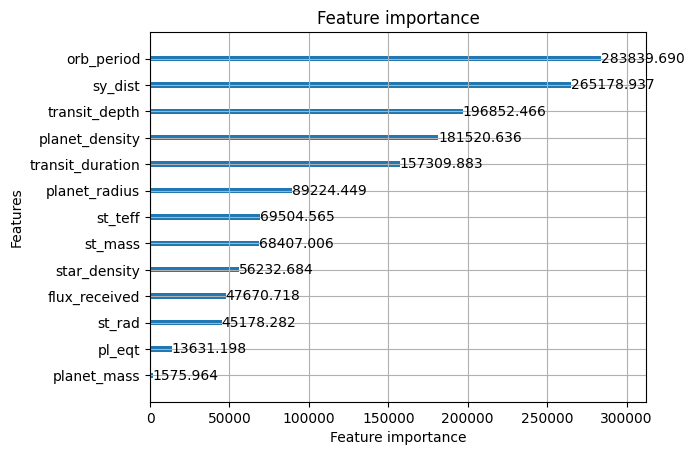

In [21]:
import matplotlib.pyplot as plt
import lightgbm as lgb

lgb.plot_importance(model, max_num_features=15, importance_type='gain')
plt.show()